# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

In [485]:
#importando as bibliotecas
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [486]:
import warnings 
warnings.filterwarnings(action = 'ignore')

## Importando dados

In [487]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [488]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [489]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.03.2023,105.071,106.540,106.724,105.053,"19,17M","-1,38%"
1,08.03.2023,106.540,104.228,106.721,104.228,"15,90M","2,22%"
2,07.03.2023,104.228,104.700,105.179,103.480,"12,58M","-0,45%"
3,06.03.2023,104.700,103.865,105.171,103.170,"14,28M","0,80%"
4,03.03.2023,103.866,103.326,104.440,103.323,"13,10M","0,52%"


## Tratamento de dados

In [490]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [491]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1756,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [492]:
df.drop(1756, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [493]:
#verificando valores duplicados
df.duplicated().sum()

0

In [494]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [495]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'fechamento', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
df.columns

Index(['data', 'fechamento', 'abertura', 'maxima', 'minima', 'volume',
       'variacao'],
      dtype='object')

In [496]:
#alterando tipo da coluna de data
df['volume'] = df['volume'].str.replace(',', '.')
df['volume'] = df['volume'].str.replace('K', '')
df['volume'] = df['volume'].str.replace('M', '').astype(float)
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [497]:
df.head(3)

,data,fechamento,abertura,maxima,minima,volume,variacao
0,2023-03-09,105.071,106.540,106.724,105.053,19.17,-1.38
1,2023-03-08,106.540,104.228,106.721,104.228,15.90,2.22
2,2023-03-07,104.228,104.700,105.179,103.480,12.58,-0.45


In [498]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        4999 non-null   datetime64[ns]
 1   fechamento  4999 non-null   float64       
 2   abertura    4999 non-null   float64       
 3   maxima      4999 non-null   float64       
 4   minima      4999 non-null   float64       
 5   volume      4999 non-null   float64       
 6   variacao    4999 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 312.4 KB


In [499]:
df.describe()

,data,fechamento,abertura,maxima,minima,volume,variacao
count,4999,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,2013-02-01 23:28:01.536307200,62.257776,62.239705,62.876103,61.606323,59.327031,0.059628
min,2003-01-02 00:00:00,9.995000,10.006000,10.151000,9.968000,1.000000,-14.780000
25%,2008-01-15 12:00:00,45.508000,45.489000,45.978000,45.019500,2.900000,-0.850000
50%,2013-02-04 00:00:00,58.083000,58.076000,58.634000,57.534000,4.620000,0.090000
75%,2018-02-24 12:00:00,76.042000,76.021500,76.698000,75.307500,17.665000,1.015000
max,2023-03-09 00:00:00,130.776000,130.776000,131.190000,129.526000,999.460000,14.660000
std,NaN,28.202120,28.204606,28.422032,27.973578,133.044930,1.720338


In [500]:
df = df.sort_values(by = 'data')
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao
4999,2003-01-02,11.603,11.291,11.603,11.291,195.13,2.97
4998,2003-01-03,11.600,11.632,11.798,11.600,197.05,-0.02
4997,2003-01-06,12.020,11.636,12.032,11.633,398.40,3.62
4996,2003-01-07,11.876,12.010,12.018,11.842,387.98,-1.19
4995,2003-01-08,11.786,11.875,11.928,11.757,217.19,-0.76


In [501]:
#criando novos campos de medias móveis
df['media_movel_5d'] = df['fechamento'].rolling(5).mean()
df['media_movel_21d'] = df['fechamento'].rolling(21).mean()

In [502]:
#empurrando para frente os valores das ações
df['fechamento'] = df['fechamento'].shift(-1)
df.head()

,data,fechamento,abertura,maxima,minima,volume,variacao,media_movel_5d,media_movel_21d
4999,2003-01-02,11.600,11.291,11.603,11.291,195.13,2.97,NaN,NaN
4998,2003-01-03,12.020,11.632,11.798,11.600,197.05,-0.02,NaN,NaN
4997,2003-01-06,11.876,11.636,12.032,11.633,398.40,3.62,NaN,NaN
4996,2003-01-07,11.786,12.010,12.018,11.842,387.98,-1.19,NaN,NaN
4995,2003-01-08,11.912,11.875,11.928,11.757,217.19,-0.76,11.777,NaN


In [503]:
#retirando os dados nulos
df.dropna(inplace = True)
df

,data,fechamento,abertura,maxima,minima,volume,variacao,media_movel_5d,media_movel_21d
4979,2003-01-30,10.941,10.873,11.001,10.705,262.67,-1.04,10.6890,11.512190
4978,2003-01-31,10.910,10.761,11.004,10.741,276.11,1.77,10.7204,11.480667
4977,2003-02-03,10.577,10.943,11.067,10.852,229.17,-0.28,10.7964,11.447810
4976,2003-02-04,10.592,10.879,10.879,10.534,287.12,-3.05,10.8084,11.379095
4975,2003-02-05,10.566,10.581,10.761,10.497,342.69,0.14,10.7542,11.317952
...,...,...,...,...,...,...,...,...,...
5,2023-03-02,103.866,104.375,104.912,103.321,14.74,-1.01,104.8304,108.145619
4,2023-03-03,104.700,103.326,104.440,103.323,13.10,0.52,104.4440,107.690143
3,2023-03-06,104.228,103.865,105.171,103.170,14.28,0.80,104.2418,107.339000
2,2023-03-07,106.540,104.700,105.179,103.480,12.58,-0.45,104.1010,107.057429


In [504]:
#reindexando o data frame
df = df.reset_index(drop = True)
df

,data,fechamento,abertura,maxima,minima,volume,variacao,media_movel_5d,media_movel_21d
0,2003-01-30,10.941,10.873,11.001,10.705,262.67,-1.04,10.6890,11.512190
1,2003-01-31,10.910,10.761,11.004,10.741,276.11,1.77,10.7204,11.480667
2,2003-02-03,10.577,10.943,11.067,10.852,229.17,-0.28,10.7964,11.447810
3,2003-02-04,10.592,10.879,10.879,10.534,287.12,-3.05,10.8084,11.379095
4,2003-02-05,10.566,10.581,10.761,10.497,342.69,0.14,10.7542,11.317952
...,...,...,...,...,...,...,...,...,...
4973,2023-03-02,103.866,104.375,104.912,103.321,14.74,-1.01,104.8304,108.145619
4974,2023-03-03,104.700,103.326,104.440,103.323,13.10,0.52,104.4440,107.690143
4975,2023-03-06,104.228,103.865,105.171,103.170,14.28,0.80,104.2418,107.339000
4976,2023-03-07,106.540,104.700,105.179,103.480,12.58,-0.45,104.1010,107.057429


In [522]:
#verificando quantidade de linhas
qtd_linhas = len(df)

qtd_linhas_treino = round(.7 * (qtd_linhas - round(qtd_linhas * 0.01)))
qtd_linhas_teste = (qtd_linhas - round(qtd_linhas * 0.01)) - qtd_linhas_treino  
qtd_linhas_validacao = round(qtd_linhas * 0.01)

info = (
    f'linhas treino = 0:{qtd_linhas_treino}'
    f' linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}'
    f' linhas validação = {qtd_linhas_treino + qtd_linhas_teste}:{(qtd_linhas_treino + qtd_linhas_teste) + qtd_linhas_validacao}'
)

info

'linhas treino = 0:3450 linhas teste = 3450:4928 linhas validação = 4928:4978'

In [506]:
qtd_linhas_treino, qtd_linhas_teste, qtd_linhas_validacao

(3450, 1478, 50)

In [507]:
#separando as features e labels
features = df.drop(['fechamento', 'data'], axis = 1)
labels = df['fechamento']

In [508]:
#escolhendo as melhores features com Kbest
features_list = features.columns.to_list()

k_best_features = SelectKBest(k = 'all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ('Melhores features:')
print (k_best_features_final)


Melhores features:
{'minima': 754.1807853074254, 'volume': 697.101031344154, 'maxima': 479.9052869797996, 'media_movel_21d': 404.31145262050103, 'variacao': 2.6264300805820007, 'media_movel_5d': 1.1665765453049914}


In [509]:
#separando as features escolhidas
features = df.loc[:,['maxima','minima','volume','media_movel_21d']]

In [510]:
features

,maxima,minima,volume,media_movel_21d
0,11.001,10.705,262.67,11.512190
1,11.004,10.741,276.11,11.480667
2,11.067,10.852,229.17,11.447810
3,10.879,10.534,287.12,11.379095
4,10.761,10.497,342.69,11.317952
...,...,...,...,...
4973,104.912,103.321,14.74,108.145619
4974,104.440,103.323,13.10,107.690143
4975,105.171,103.170,14.28,107.339000
4976,105.179,103.480,12.58,107.057429


In [511]:
#separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

3450 3450
1478 1478


In [512]:
#normalizando os dados de entrada(features)

#gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  #normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       #normalizando os dados de entrada(teste)

In [513]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred = lr.predict(X_test_scale)
cd = r2_score(y_test, pred)

f'Coeficiente de determinação: {cd * 100:.2f}'

'Coeficiente de determinação: 99.24'

In [523]:
features.tail(50)

,maxima,minima,volume,media_movel_21d
4928,109.755,108.309,5.22,107.747810
4929,109.353,107.418,11.16,107.738095
4930,110.536,108.578,11.19,107.706048
4931,111.178,109.560,13.39,107.575048
4932,109.734,105.981,8.13,107.358381
4933,106.684,103.852,14.47,106.988952
4934,105.627,103.915,14.45,106.795286
4935,107.743,105.333,15.51,106.673952
4936,109.433,107.642,12.63,106.668952
4937,109.938,108.134,12.05,106.758524


In [526]:
dados_novos = features.tail(50)
dados_novos.tail()

,maxima,minima,volume,media_movel_21d
4973,104.912,103.321,14.74,108.145619
4974,104.440,103.323,13.10,107.690143
4975,105.171,103.170,14.28,107.339000
4976,105.179,103.480,12.58,107.057429
4977,106.721,104.228,15.90,106.963000


In [528]:
#executando a previsão
dados_novos = scaler.transform(dados_novos)
pred = lr.predict(dados_novos)
pred

array([108.90645369, 108.25580176, 109.43799875, 110.25687545,
       107.7358263 , 105.12326279, 104.61934715, 106.40606818,
       108.42076759, 108.92270518, 109.73108659, 111.55543042,
       111.95868474, 111.02603503, 109.70818677, 110.27403406,
       112.26303482, 112.12432865, 112.26103968, 112.18073726,
       112.23198056, 113.06297625, 114.10006864, 112.9977858 ,
       112.23975475, 112.78835396, 112.02798786, 111.20140581,
       109.2129853 , 107.89994292, 107.95851901, 108.83579907,
       108.74128272, 107.95803748, 108.13747098, 108.3952181 ,
       108.57938591, 109.25198753, 109.2971488 , 107.78567141,
       107.53327453, 106.31673162, 105.64005305, 105.69631405,
       104.12684349, 103.94286228, 103.70926692, 104.00854516,
       104.17111577, 105.33022938])

In [529]:
data = df['data'].tail(50)
res = df['fechamento'].tail(50)

df_resultado = pd.DataFrame({'data': data, 'real': res, 'pred': pred})
df_resultado['real'] = df_resultado['real'].shift()
df_resultado.set_index('data', inplace = True)
df_resultado

,real,pred
data,,
2022-12-26,NaN,108.906454
2022-12-27,108.578,108.255802
2022-12-28,110.237,109.437999
2022-12-29,109.735,110.256875
2023-01-02,106.376,107.735826
2023-01-03,104.166,105.123263
2023-01-04,105.334,104.619347
2023-01-05,107.641,106.406068
2023-01-06,108.964,108.420768


<Axes: xlabel='data'>

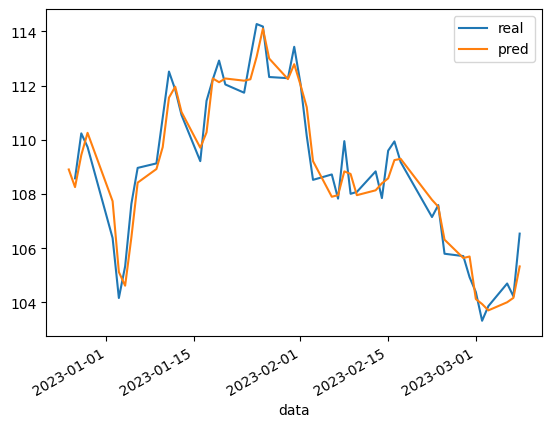

In [519]:
df_resultado.plot()

In [539]:
import numpy as np

def wmape(y_test, y_pred):
    return np.abs(y_test - y_pred).sum() / np.abs(y_test).sum()

In [540]:
df_resultado.dropna(inplace = True)
acuracia = wmape(df_resultado['real'].values, df_resultado['pred'].values)
print(f'WMAPE: {acuracia:.2%}')

WMAPE: 0.53%
